# Weight initialization

Source: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/weight-initialization/weight_initialization_exercise.ipynb

References:
- [Weight Initialization in Neural Networks: A Journey From the Basics to Kaiming](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79)

In [23]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
batch_size = 100
valid_size = 0.2

In [4]:
transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root='data/', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data/', train=False, download=True, transform=transform)

100.0%

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


111.0%

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw


100.0%

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


159.1%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!


## Split train dataset into train and valid dataloaders

In [13]:
indices = list(range(len(train_data)))
np.random.shuffle(indices)
n_val_indices = int(np.floor(len(train_data)*valid_size))
train_idx = indices[:n_train_examples]
valid_idx = indices[n_train_examples:] 

In [14]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [18]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

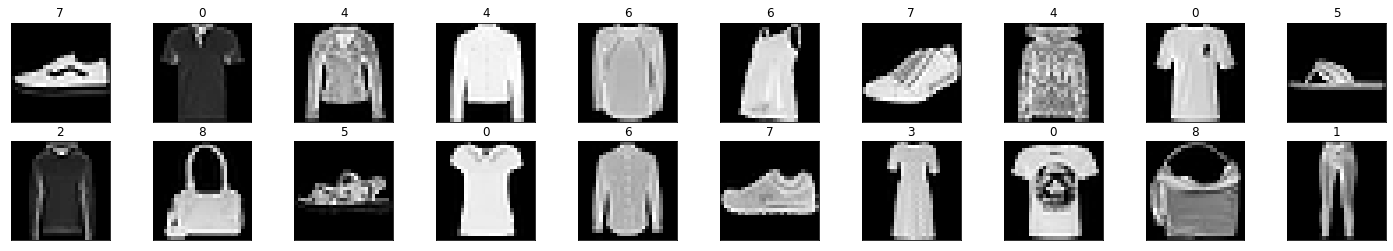

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

In [25]:
class Net(nn.Module):
    def __init__(self, hidden_1=256, hidden_2=128):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        self.dropout = nn.Dropout(0.2)
            
            
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

## Vaious initializations

In [27]:
def weights_init_zeros(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight, 0.)
        nn.init.zeros_(m.bias)

def weights_init_ones(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight, 1.)
        nn.init.zeros_(m.bias)

def weights_init_uniform(m):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, 0., 1.)
        nn.init.zeros_(m.bias)

def weights_init_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0., 1.)
        nn.init.zeros_(m.bias)

def weights_init_sqrt_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=1./np.sqrt(m.in_features))
        nn.init.zeros_(m.bias)

In [36]:
model = Net()
model_zeros = Net().apply(weights_init_zeros)
model_ones = Net().apply(weights_init_ones)
model_uniform = Net().apply(weights_init_uniform)
model_normal = Net().apply(weights_init_normal)
model_sqrt_normal = Net().apply(weights_init_sqrt_normal)

## Helper functions

In [37]:
def _get_loss_acc(model, train_loader, valid_loader):
    """
    Get losses and validation accuracy of example neural network
    """
    n_epochs = 2
    learning_rate = 0.001
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    loss_batch = []

    model.train()
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss_batch.append(loss.item())
             
    model.eval()
    correct = 0
    total = 0
    for data, target in valid_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum()
      
    valid_acc = correct.item() / total

    return loss_batch, valid_acc


def compare_init_weights(
        model_list,
        plot_title,
        train_loader,
        valid_loader,
        plot_n_batches=100):
    """
    Plot loss and print stats of weights using an example neural network
    """
    colors = ['r', 'b', 'g', 'c', 'y', 'k']
    label_accs = []
    label_loss = []

    assert len(model_list) <= len(colors), 'Too many initial weights to plot'

    for i, (model, label) in enumerate(model_list):
        loss, val_acc = _get_loss_acc(model, train_loader, valid_loader)

        plt.plot(loss[:plot_n_batches], colors[i], label=label)
        label_accs.append((label, val_acc))
        label_loss.append((label, loss[-1]))

    plt.title(plot_title)
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    print('After 2 Epochs:')
    print('Validation Accuracy')
    for label, val_acc in label_accs:
        print('  {:7.3f}% -- {}'.format(val_acc*100, label))
    print('Training Loss')
    for label, loss in label_loss:
        print('  {:7.3f}  -- {}'.format(loss, label))
        

def hist_dist(title, distribution_tensor, hist_range=(-4, 4)):
    """
    Display histogram of values in a given distribution tensor
    """
    plt.title(title)
    plt.hist(distribution_tensor, np.linspace(*hist_range, num=len(distribution_tensor)/2))
    plt.show()

## Let's plot 

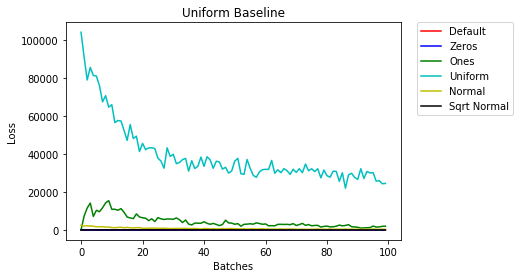

After 2 Epochs:
Validation Accuracy
   82.379% -- Default
    9.902% -- Zeros
    9.979% -- Ones
   10.029% -- Uniform
   69.581% -- Normal
   82.842% -- Sqrt Normal
Training Loss
    0.595  -- Default
    2.303  -- Zeros
  2584.359  -- Ones
  21133.037  -- Uniform
  219.117  -- Normal
    0.450  -- Sqrt Normal


In [38]:
model_list = [
    (model, "Default"), 
    (model_zeros, "Zeros"),
    (model_ones, "Ones"),
    (model_uniform, "Uniform"),
    (model_normal, "Normal"),
    (model_sqrt_normal, "Sqrt Normal"),
]
compare_init_weights(model_list,  'Uniform Baseline', train_loader, valid_loader)

Notice that the loss is very small for zeros. Can you guess why this could be?

In [43]:
-np.log(1/10.)

2.3025850929940455